In [1]:
import os
import sys

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from tqdm.autonotebook import tqdm

import pdb

sys.path.append('../')

import random

random.seed(0)
np.random.seed(0)

/home/msesia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  del sys.path[0]


In [2]:
from sklearn.model_selection import train_test_split

from simconfcal.models import OutlierDataModel

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

random_state = 2021

p = 10
model = OutlierDataModel(p, random_state=random_state)

n = 1000
X_clean, _ = model.sample(n, purity=1)

# Split data into training and calibration subsets
X_train, X_calib = train_test_split(X_clean, test_size=0.5, random_state=random_state)

# Choose a one-class classifier algorithm
method_oneclass = "IForest"

# Initialize the one-class classifier
contamination = 0.001
contamination = min(max(contamination,0.004),0.1)
if method_oneclass == "SVM":
    clf = svm.OneClassSVM(nu=contamination, kernel="rbf", gamma=0.1)
if method_oneclass == "IForest":
    clf = IsolationForest(random_state=random_state, contamination=contamination, behaviour="new")
if method_oneclass == "Neighbors":
    clf = LocalOutlierFactor(novelty=True, contamination=contamination)
    
# Fit the black-box model
clf.fit(X_train)

# Compute scores on calibration data
scores_cal = clf.score_samples(X_calib)

# Compute empirical CDF of scores on calibration data
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(scores_cal)

In [3]:
# Generate test data
X_test, is_outlier = model.sample(n, purity=0.9)

# Evaluate scores on test data and sort them
scores_test = clf.score_samples(X_test)
scores_test = np.sort(scores_test)

# Evaluate empirical CDF of calibration scores on test scores
empirical_cdf = ecdf(scores_test)

In [4]:
## Generate a large independent data set
X_big, _ = model.sample(100000, purity=1)
scores_big = clf.score_samples(X_big)

# Estimate true CDF of calibration scores
tcdf = ECDF(scores_big)
true_cdf = tcdf(scores_test)

In [5]:
from simconfcal.outliers import CDFConfidenceBand

cband = CDFConfidenceBand(scores_cal, delta=0.05)
lower, upper, scores_test = cband.evaluate(scores_test)

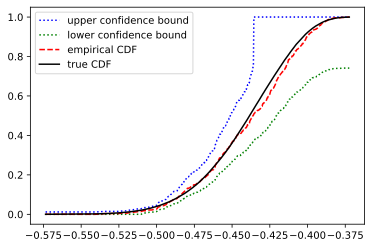

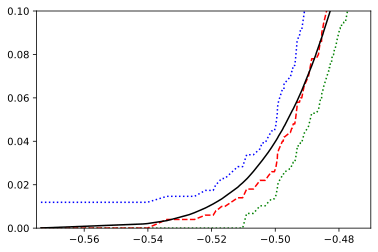

In [6]:
def plot_bands(x, upper, lower, empirical, true=None, xlim=None, ylim=None, legend=False):
    plt.plot(x, upper, label="upper confidence bound", linestyle=":", color="blue")
    plt.plot(x, lower, label="lower confidence bound", linestyle=":", color="green")
    plt.plot(x, empirical, label="empirical CDF", linestyle="--", color="red")
    if true is not None:
        plt.plot(x, true, label="true CDF", linestyle="-", color="black")

    if legend:
        plt.legend()
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.show()

plot_bands(scores_test, upper, lower, empirical_cdf, true_cdf, legend=True)
plot_bands(scores_test, upper, lower, empirical_cdf, true_cdf, xlim=[-0.575, -0.47], ylim=[0,0.1])

In [9]:
# Save results
df = pd.DataFrame({'x':scores_test, 
              'upper':upper, 'lower':lower,
              'empirical':empirical_cdf, 'true':true_cdf
             })
df.to_csv('tmp/bands.txt', index=False)